# Illustration of autoephaptic coupling

In [1]:
%matplotlib inline
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import LFPy
import neuron
import brainsignals.neural_simulations as ns
from brainsignals.plotting_convention import mark_subplots, simplify_axes

ns.load_mechs_from_folder(ns.cell_models_folder)
ns.load_mechs_from_folder(join(ns.hay_folder, "mod"))
np.random.seed(12345)

tstop = 30
dt = 2**-6
sigma = 0.3

In [2]:
def return_hay_cell(tstop, dt):
    cell_params = {
        'morphology': join(ns.hay_folder, "morphologies", "cell1.asc"),
        'templatefile': [join(ns.hay_folder, 'models', 'L5PCbiophys3.hoc'),
                         join(ns.hay_folder, 'models', 'L5PCtemplate.hoc')],
        'templatename': 'L5PCtemplate',
        'templateargs': join(ns.hay_folder, 'morphologies', 'cell1.asc'),
        'passive': False,
        'nsegs_method': None,
        'dt': dt,
        'tstart': -200,
        'tstop': tstop,
        'v_init': -75,
        'celsius': 34,
        'pt3d': True,
        'extracellular': True,
    }
    cell = LFPy.TemplateCell(**cell_params)
    cell.set_rotation(x=4.729, y=-3.166)
    return cell


def insert_synaptic_input(cell, synidx):

    synapse_parameters = dict(
                          idx = synidx,
                          e = 0., # reversal potential
                          weight = 0.15, # synapse weight
                          record_current = True, # record synapse current
                          syntype = 'Exp2Syn',
                          tau1 = 0.1, #Time constant, rise
                          tau2 = 1.0, #Time constant, decay
                          )
    synapse = LFPy.Synapse(cell, **synapse_parameters)
    synapse.set_spike_times(np.array([3.]))
    return synapse, cell

In [3]:
cell = return_hay_cell(tstop, dt)
plot_idxs = [cell.get_closest_idx(0, 0, np.max(cell.z)),
             cell.get_closest_idx(0, 0, np.max(cell.z) / 2),
             cell.get_closest_idx(0, 0, 0),
             ]
plot_idx_clrs = ['b', 'gray', 'r']

# Store for later plotting:
cell_x = cell.x.copy()
cell_z = cell.z.copy()

elec_params = dict(
            sigma = sigma,      # extracellular conductivity
            x = cell.x.mean(axis=1),
            y = cell.y.mean(axis=1),
            z = cell.z.mean(axis=1),
            method = 'pointsource',
        )
elec = LFPy.RecExtElectrode(cell, **elec_params)
M_elec = elec.get_transformation_matrix().copy()

synidx = cell.get_closest_idx(x=0, y=0, z=0)

# Original un-ephaptic simulation:
syn, cell = insert_synaptic_input(cell, synidx)
cell.simulate(rec_imem=True, rec_vmem=True)
t = cell.tvec.copy()
v_orig = cell.vmem.copy()
self_caused_pot = M_elec @ cell.imem
self_caused_pot_orig = self_caused_pot.copy()
cell.__del__()

for iteration in range(5):
    cell = return_hay_cell(tstop, dt)
    syn, cell = insert_synaptic_input(cell, synidx)
    cell.insert_v_ext(self_caused_pot, t)

    cell.simulate(rec_imem=True, rec_vmem=True)
    self_caused_pot_ = M_elec @ cell.imem
    vmem = cell.vmem.copy()
    max_error = np.max(np.abs((self_caused_pot_ - self_caused_pot)) /
                 np.max(np.abs(self_caused_pot)))
    print("Max relative error: {:1.5f}".format(max_error))
    self_caused_pot = self_caused_pot_
    del cell
    del syn


Changing temperature 34.00 to 34.00
Max relative error: 0.05995
Changing temperature 34.00 to 34.00
Max relative error: 0.00298
Changing temperature 34.00 to 34.00
Max relative error: 0.00010
Changing temperature 34.00 to 34.00
Max relative error: 0.00001
Changing temperature 34.00 to 34.00
Max relative error: 0.00000


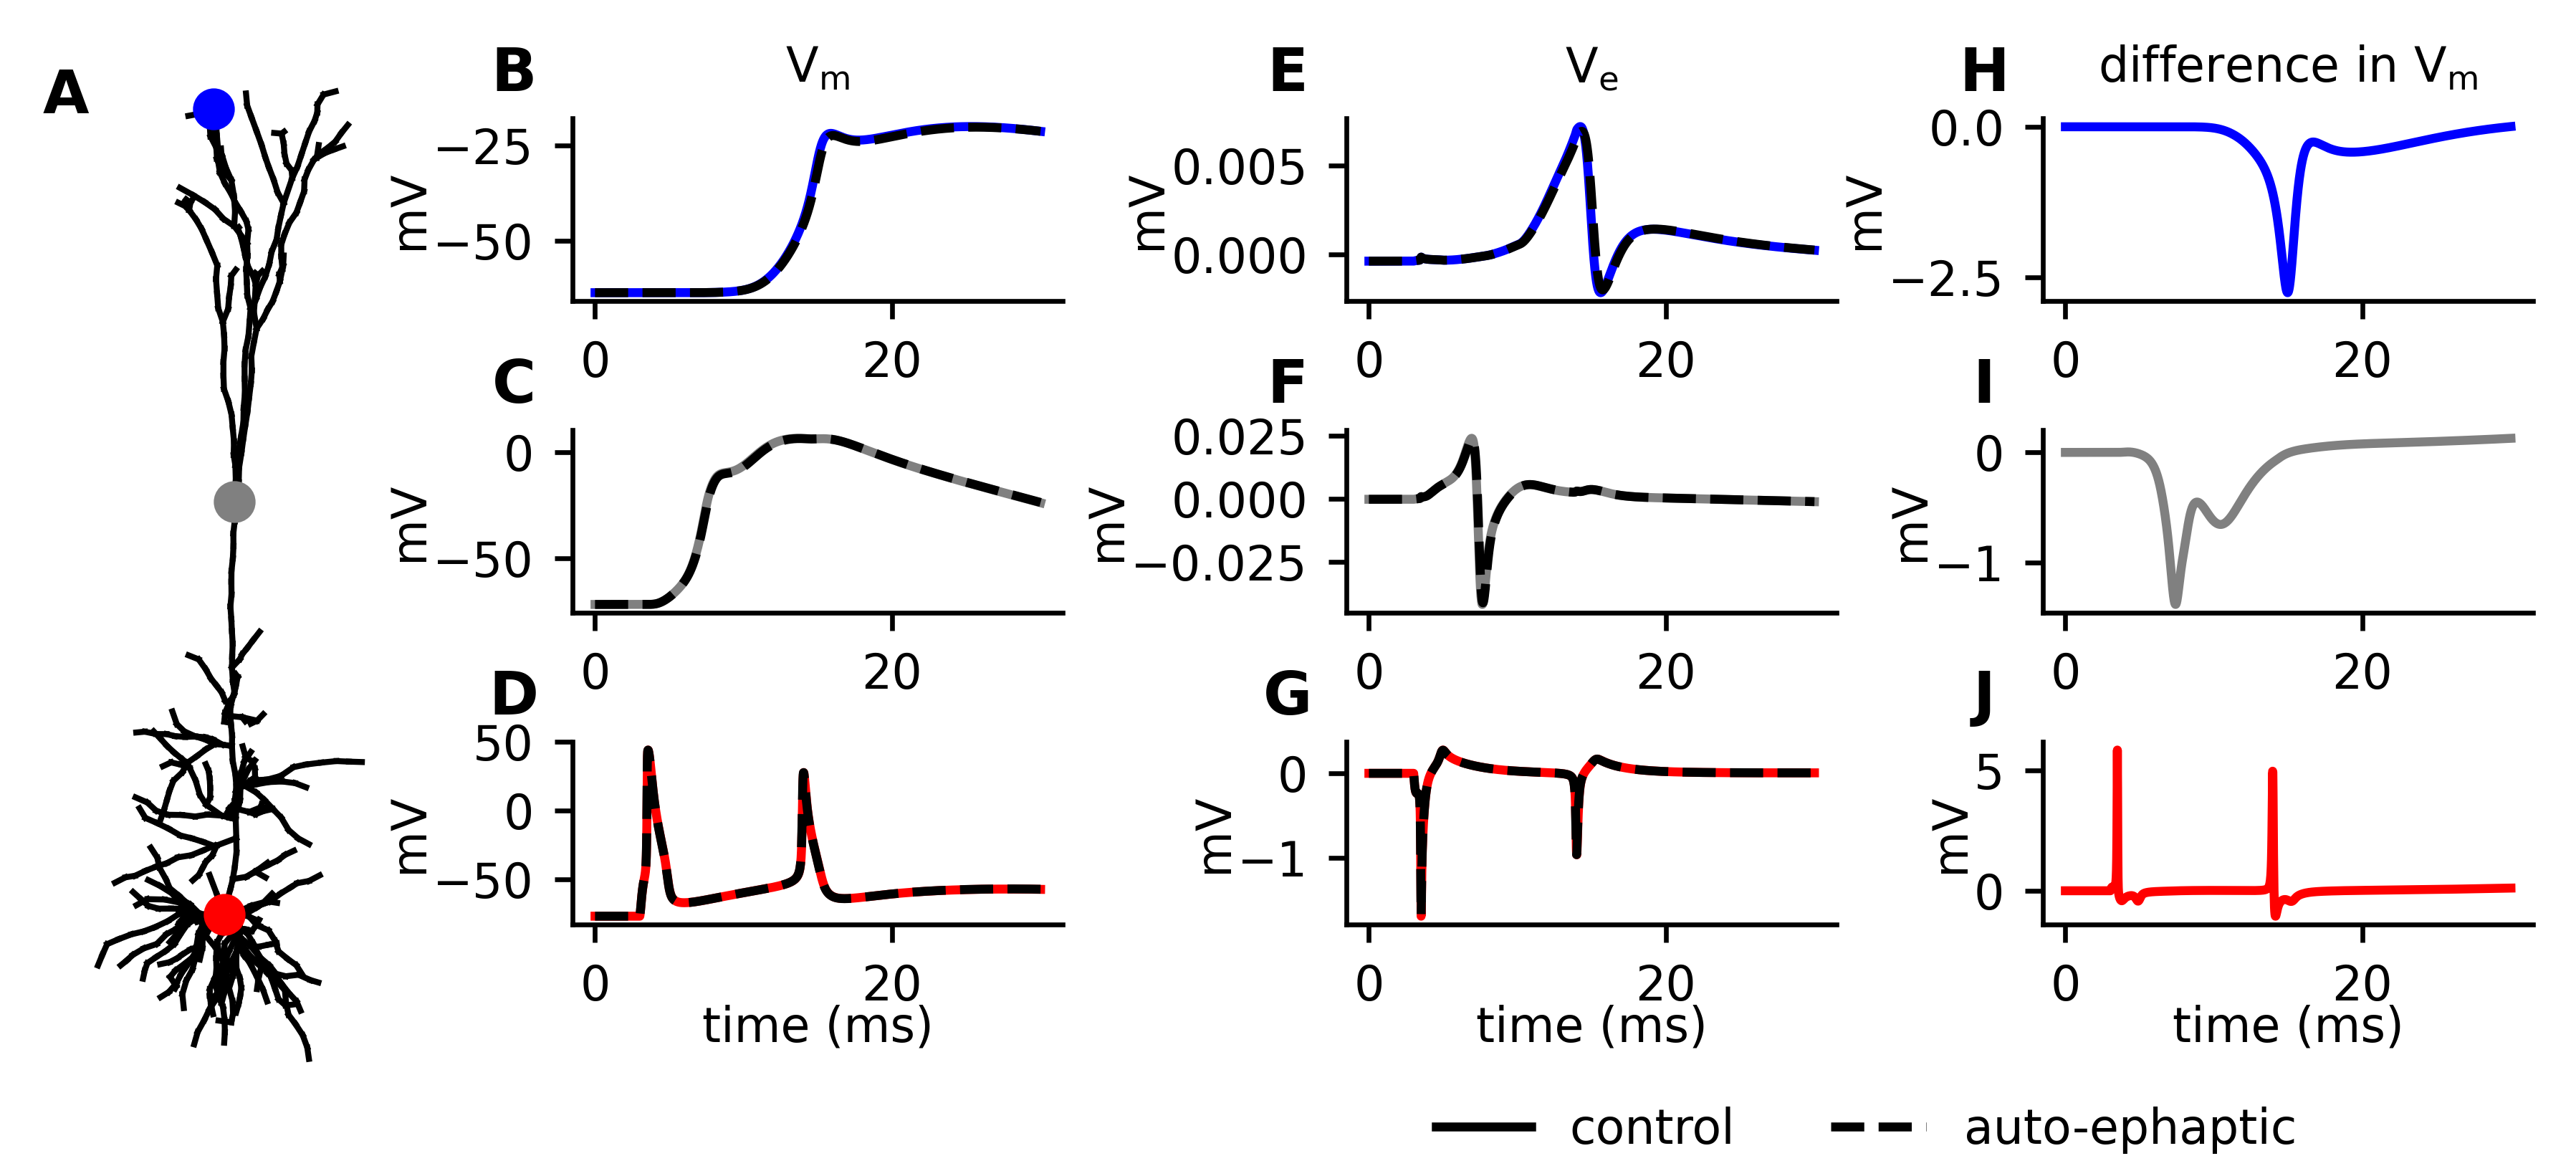

In [4]:

fig = plt.figure()

ax1 = fig.add_axes([0.0, 0.0, 0.15, 0.99], aspect=1, xlim=[-250, 250],
                   frameon=False, xticks=[], yticks=[])
ax1.plot(cell_x.T, cell_z.T, 'k', lw=1)

for i, comp in enumerate(plot_idxs):
    c = plot_idx_clrs[i]
    ax1.plot(cell_x[comp].mean(), cell_z[comp].mean(), 'o', c=c)
    ax_v = fig.add_axes([0.21, 0.75 - i / 3 * 0.87, 0.19, 0.17],
                           ylabel="mV",)
    ax_ecp = fig.add_axes([0.51, 0.75 - i / 3 * 0.87, 0.19, 0.17],
                           ylabel="mV",)
    ax_diff = fig.add_axes([0.78, 0.75 - i / 3 * 0.87, 0.19, 0.17],
                           ylabel="mV",)
    if i == 0:
        ax_v.set_title(r"V$_{\rm m}$")
        ax_ecp.set_title(r"V$_{\rm e}$")
        ax_diff.set_title(r"difference in V$_{\rm m}$")
    if i == 2:
        ax_v.set_xlabel("time (ms)", labelpad=-1)
        ax_ecp.set_xlabel("time (ms)", labelpad=-1)
        ax_diff.set_xlabel("time (ms)", labelpad=-1)

    ax_v.plot(t, v_orig[comp], c=c)
    ax_v.plot(t, vmem[comp], c='k', ls='--')

    ax_diff.plot(t, vmem[comp] - v_orig[comp], c=c)

    l_orig, = ax_ecp.plot(t, self_caused_pot_orig[comp], c=c)
    l_efap, = ax_ecp.plot(t, self_caused_pot[comp], c='k', ls='--')

l_orig, = ax_ecp.plot([], [], c='k')

mark_subplots(fig.axes[0], "A", ypos=0.95, xpos=0.05)
mark_subplots(fig.axes[1:], "BEHCFIDGJ", ypos=1.24)
simplify_axes(fig.axes)
fig.legend([l_orig, l_efap], ["control", "auto-ephaptic"], ncol=2,
           loc=(0.55, -0.01), frameon=False)

plt.savefig("fig_ephaptic_hay_active.pdf")


#  Figure caption: Auto-ephaptic coupling

__A__ : The Hay model, driven to fire action potentials by a strong synaptic input to the soma.

__B__,__C__,__D__: Membrane potential at three different positions (marked in panel A). The full lines of different colors corespond to the different locations, without auto-ephaptic effects. The dashed lines show the result of an iterative procedure, where the simulated extracellular potential outside every cellular compartment is in the next iteration used as a boundary condition, until the predicted and enforced extracellular potentials have converged. In practice a few iterations are sufficient. 

__E__, __F__, __G__: Extracellular potential at three different positions, corresponding to directly outside the membrane of the different locations marked in panel A. Extracellular potetials like these are used as a boundary condition in the simulations.

__H__, __I__, __J__: Difference between control and auto-ephaptic in panel B-D.
